# Geometry operations {#geometric-operations}

## Prerequisites

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

Packages...

In [2]:
import shapely.geometry
import geopandas as gpd
import topojson as tp

Sample data...

In [3]:
seine = gpd.read_file("data/seine.gpkg")
us_states = gpd.read_file("data/us_states.gpkg")
nz = gpd.read_file("data/nz.gpkg")

## Introduction

So far the book has explained the structure of geographic datasets (Chapter 2), and how to manipulate them based on their non-geographic attributes (Chapter 3) and spatial relations (Chapter 4). This chapter focusses on manipulating the geographic elements of geographic objects, for example by simplifying and converting vector geometries, cropping raster datasets, and converting vector objects into rasters and from rasters into vectors. After reading it---and attempting the exercises at the end---you should understand and have control over the geometry column in sf objects and the extent and geographic location of pixels represented in rasters in relation to other geographic objects.

@sec-geo-vec covers transforming vector geometries with 'unary' and 'binary' operations. Unary operations work on a single geometry in isolation, including simplification (of lines and polygons), the creation of buffers and centroids, and shifting/scaling/rotating single geometries using 'affine transformations' (@sec-simplification to @sec-affine-transformations). Binary transformations modify one geometry based on the shape of another, including clipping and geometry unions, covered in @sec-clipping and @sec-geometry-unions, respectively. Type transformations (from a polygon to a line, for example) are demonstrated in Section @sec-type-transformations.

@sec-geo-ras covers geometric transformations on raster objects. This involves changing the size and number of the underlying pixels, and assigning them new values. It teaches how to change the resolution (also called raster aggregation and disaggregation), the extent and the origin of a raster. These operations are especially useful if one would like to align raster datasets from diverse sources. Aligned raster objects share a one-to-one correspondence between pixels, allowing them to be processed using map algebra operations, described in Section 4.3.2. The final Section 6 connects vector and raster objects. It shows how raster values can be 'masked' and 'extracted' by vector geometries. Importantly it shows how to 'polygonize' rasters and 'rasterize' vector datasets, making the two data models more interchangeable.

## Geometric operations on vector data {#sec-geo-vec}

This section is about operations that in some way change the geometry of vector layers. It is more advanced than the spatial data operations presented in the previous chapter (in @sec-spatial-vec), because here we drill down into the geometry: the functions discussed in this section work on the geometric (`GeoSeries`) part, either as standalone object or as part of a `GeoDataFrame`.

### Simplification {#sec-simplification}

Simplification is a process for generalization of vector objects (lines and polygons) usually for use in smaller scale maps. Another reason for simplifying objects is to reduce the amount of memory, disk space and network bandwidth they consume: it may be wise to simplify complex geometries before publishing them as interactive maps. The `geopandas` package provides the `.simplify` method, which uses the GEOS implementation of the Douglas-Peucker algorithm to reduce the vertex count. `.simplify` uses the `tolerance` to control the level of generalization in map units (see Douglas and Peucker 1973 for details). 

For example, a simplified geometry of a `"LineString"` geometry, representing the river Seine and tributaries, using tolerance of `2000` meters, can created using the following command:

In [4]:
seine_simp = seine.simplify(2000)  # 2000 m

Figure @fig-simplify-lines illustrates the input and the result of the simplification:

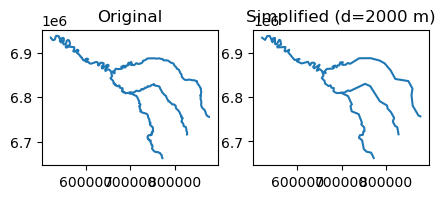

In [5]:
#| label: fig-simplify-lines
#| fig-cap: Comparison of the original and simplified geometry of the seine object. 

fig, axes = plt.subplots(ncols=2)
seine.plot(ax=axes[0])
seine_simp.plot(ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Simplified (d=2000 m)');

The resulting `seine_simp` object is a copy of the original `seine` but with fewer vertices. This is apparent, with the result being visually simpler (@fig-simplify-lines, right) and consuming less memory than the original object, as verified below:

In [6]:
import sys
sys.getsizeof(seine)       ## Original (bytes)

354

In [7]:
sys.getsizeof(seine_simp)  ## Simplified (bytes)

168

Simplification is also applicable for polygons. This is illustrated using `us_states`, representing the contiguous United States. As we show in @sec-reproj-geo-data, GEOS assumes that the data is in a projected CRS and this could lead to unexpected results when using a geographic CRS. Therefore, the first step is to project the data into some adequate projected CRS, such as US National Atlas Equal Area (epsg = `2163`) (on the left in Figure @fig-simplify-polygons):

In [8]:
us_states2163 = us_states.to_crs(2163)

The `.simplify` method from `geopandas` works the same way with a `"Polygon"`/`"MultiPolygon"` layer such as `us_states2163`:

In [9]:
us_states_simp1 = us_states2163.simplify(100000)

A limitation with `.simplify` is that it simplifies objects on a per-geometry basis. This means the "topology" is lost, resulting in overlapping and "holey" areal units illustrated in Figure @fig-simplify-polygons (middle panel). The `toposimplify` function from `topojson` provides an alternative that overcomes this issue. By [default](https://mattijn.github.io/topojson/example/settings-tuning.html#simplify_algorithm) it uses the Douglas-Peucker algorithm like the `.simplify` method. Another algorithm known as Visvalingam-Whyatt, which overcomes some limitations of the Douglas-Peucker algorithm (Visvalingam and Whyatt 1993), is also available in `toposimplify`. The main advanatage of `toposimplify`, however, is that it is topologically "aware". That is, it simplifies the combined borders of the polygons (rather than each polygon on its own), thus ensuring that the overlap is maintained. The following code chunk uses this function to simplify `us_states2163`:

In [10]:
topo = tp.Topology(us_states2163, prequantize=False)
us_states_simp2 = topo.toposimplify(100000).to_gdf()

Figure @fig-simplify-polygons demonstrates the two simplification methods applied to `us_states2163`.

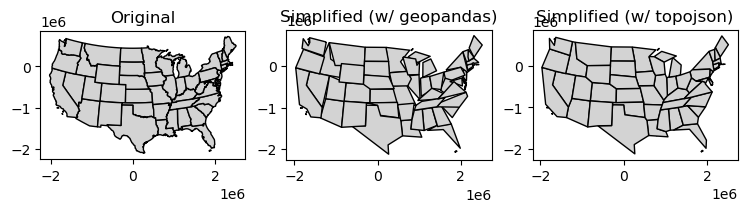

In [11]:
#| label: fig-simplify-polygons
#| fig-cap: Polygon simplification in action, comparing the original geometry of the contiguous United States with simplified versions, generated with functions from the geopandas (middle), and topojson (right), packages. 

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
us_states2163.plot(ax=axes[0], color='lightgrey', edgecolor='black')
us_states_simp1.plot(ax=axes[1], color='lightgrey', edgecolor='black')
us_states_simp2.plot(ax=axes[2], color='lightgrey', edgecolor='black')
axes[0].set_title("Original")
axes[1].set_title("Simplified (w/ geopandas)")
axes[2].set_title("Simplified (w/ topojson)");

### Centroids

Centroid operations identify the center of geographic objects. Like statistical measures of central tendency (including mean and median definitions of 'average'), there are many ways to define the geographic center of an object. All of them create single point representations of more complex vector objects.

The most commonly used centroid operation is the geographic centroid. This type of centroid operation (often referred to as 'the centroid') represents the center of mass in a spatial object (think of balancing a plate on your finger). Geographic centroids have many uses, for example to create a simple point representation of complex geometries, or to estimate distances between polygons. Centroids of the geometries in a `GeoSeries` or a `GeoDataFrame` are accessible through the `.centroid` property, as demonstrated in the code below, which generates the geographic centroids of regions in New Zealand and tributaries to the River Seine, illustrated with black points in @fig-centroid-pnt-on-surface.

In [12]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

Sometimes the geographic centroid falls outside the boundaries of their parent objects (think of a doughnut). In such cases point on surface operations can be used to guarantee the point will be in the parent object (e.g., for labeling irregular multipolygon objects such as island states), as illustrated by the red points in @fig-centroid-pnt-on-surface. Notice that these red points always lie on their parent objects. They were created with the `representative_point` method, as follows:

In [13]:
nz_pos = nz.representative_point()
seine_pos = seine.representative_point()

The centroids and points in surface are illustrated in @fig-centroid-pnt-on-surface:

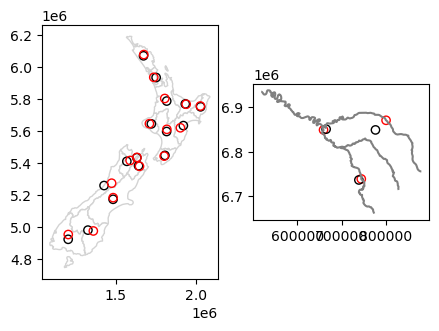

In [14]:
#| label: fig-centroid-pnt-on-surface
#| fig-cap: Centroids (black) and points on surface red of New Zealand and Seine datasets.

fig, axes = plt.subplots(ncols=2)
nz.plot(ax=axes[0], color="white", edgecolor="lightgrey")
nz_centroid.plot(ax=axes[0], color="None", edgecolor="black")
nz_pos.plot(ax=axes[0], color="None", edgecolor="red")
seine.plot(ax=axes[1], color="grey")
seine_pos.plot(ax=axes[1], color="None", edgecolor="red")
seine_centroid.plot(ax=axes[1], color="None", edgecolor="black");

### Buffers

Buffers are polygons representing the area within a given distance of a geometric feature: regardless of whether the input is a point, line or polygon, the output is a polygon. Unlike simplification (which is often used for visualization and reducing file size) buffering tends to be used for geographic data analysis. How many points are within a given distance of this line? Which demographic groups are within travel distance of this new shop? These kinds of questions can be answered and visualized by creating buffers around the geographic entities of interest.

@fig-buffers illustrates buffers of different sizes (5 and 50 km) surrounding the river Seine and tributaries. These buffers were created with commands below, which show that the `.buffer` method, applied to a `GeoSeries` (or `GeoDataFrame`) requires one important argument: the buffer distance, provided in the units of the CRS (in this case meters):

In [15]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

The 5 and 50 km buffers are visualized in @fig-buffers:

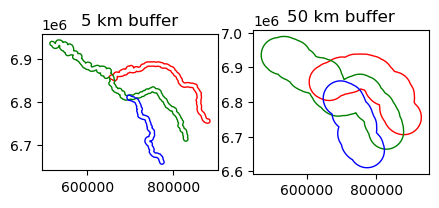

In [16]:
#| label: fig-buffers
#| fig-cap: Buffers around the Seine dataset of 5 km (left) and 50 km (right). Note the colors, which reflect the fact that one buffer is created per geometry feature.

fig, axes = plt.subplots(ncols=2)
seine_buff_5km.plot(ax=axes[0], color="none", edgecolor=["red", "green", "blue"])
seine_buff_50km.plot(ax=axes[1], color="none", edgecolor=["red", "green", "blue"])
axes[0].set_title("5 km buffer")
axes[1].set_title("50 km buffer");

Note that both `.centroid` and `.buffer` return a `GeoSeries` object, even when the input is a `GeoDataFrame`:

In [17]:
seine_buff_5km

0    POLYGON ((657550.332 6852587.97...
1    POLYGON ((517151.801 6930724.10...
2    POLYGON ((701519.740 6813075.49...
dtype: geometry

In the common scenario when the original attributes of the input features need to be retained, you can replace the existing geometry with the new `GeoSeries` as in:

In [18]:
seine_buff_5km = seine.copy()
seine_buff_5km['geometry'] = seine.buffer(5000)
seine_buff_5km

,name,geometry
0,Marne,POLYGON ((657550.332 6852587.97...
1,Seine,POLYGON ((517151.801 6930724.10...
2,Yonne,POLYGON ((701519.740 6813075.49...


### Affine transformations {#sec-affine-transformations}

Affine transformation is any transformation that preserves lines and parallelism. However, angles or length are not necessarily preserved. Affine transformations include, among others, shifting (translation), scaling and rotation. Additionally, it is possible to use any combination of these. Affine transformations are an essential part of geocomputation. For example, shifting is needed for labels placement, scaling is used in non-contiguous area cartograms, and many affine transformations are applied when reprojecting or improving the geometry that was created based on a distorted or wrongly projected map. 

The `geopandas` package implements affine transformation, for objects of classes `GeoSeries` and `GeoDataFrame`. In both cases, the method is applied on the `GeoSeries` part, returning a new `GeoSeries` of transformed geometries. 

Affine transformations of `GeoSeries` can be done using the `.affine_transform` method, which is a wrapper around the `shapely.affinity.affine_transform` function. According to the [documentation](https://shapely.readthedocs.io/en/stable/manual.html#shapely.affinity.affine_transform), a 2D affine transformation requires a six-parameter list `[a,b,d,e,xoff,yoff]` which represents the following equations for transforming the coordinates:

$$
x' = a x + b y + x_\mathrm{off}
$$

$$
y' = d x + e y + y_\mathrm{off}
$$

There are also simplified `GeoSeries` [methods](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#affine-transformations) for specific scenarios: 

* `GeoSeries.translate(xoff=0.0, yoff=0.0, zoff=0.0)`
* `GeoSeries.scale(xfact=1.0, yfact=1.0, zfact=1.0, origin='center')`
* `GeoSeries.rotate(angle, origin='center', use_radians=False)`
* `GeoSeries.skew(angle, origin='center', use_radians=False)`

For example, *shifting* only requires the $x_{off}$ and $y_{off}$, using `.translate`. The code below shifts the y-coordinates by 100,000 meters to the north, but leaves the x-coordinates untouched:

In [19]:
nz_shift = nz.translate(0, 100000)

Scaling enlarges or shrinks objects by a factor. It can be applied either globally or locally. Global scaling increases or decreases all coordinates values in relation to the origin coordinates, while keeping all geometries topological relations intact. 

`Geopandas` implements local scaling using the `.scale` method. Local scaling treats geometries independently and requires points around which geometries are going to be scaled, e.g., centroids. In the example below, each geometry is shrunk by a factor of two around the centroids (middle panel in @fig-affine-transformations). To achieve that, we pass the `0.5` and `0.5` scaling factors (for x and y, respectively), and the `"centroid"` option for the point of origin. (Other than `"centroid"`, it is possible to use `"center"` for the bounding box center, or specific point coordinates.)

In [20]:
nz_scale = nz.scale(0.5, 0.5, origin="centroid")

Rotating the geometries can be done using the `.rotate` method. When rotating, we need to specify the rotation angle (positive values imply clockwise rotation) and the `origin` points (using the same options as in `scale`). For example, the following expression rotates `nz` by 30 degrees counter-clockwise, around the geometry centroids:

In [21]:
nz_rotate = nz.rotate(-30, origin="centroid")

@fig-affine-transformations shows the original layer `nz`, and the shifting, scaling and rotation results.

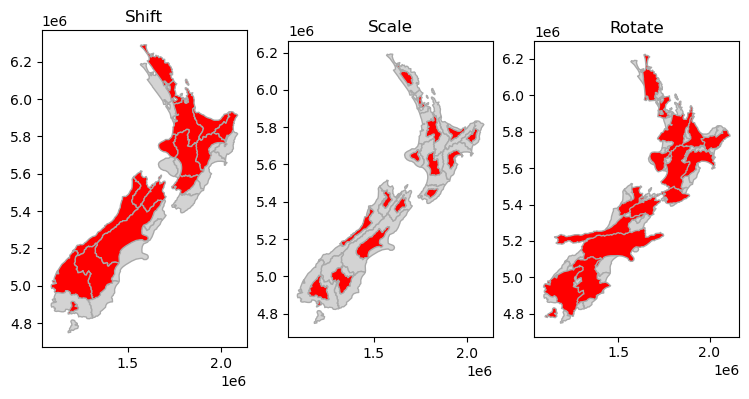

In [22]:
#| label: fig-affine-transformations
#| fig-cap: "Illustrations of affine transformations: shift, scale and rotate."

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
nz.plot(ax=axes[0], color="lightgrey", edgecolor="darkgrey")
nz_shift.plot(ax=axes[0], color="red", edgecolor="darkgrey")
nz.plot(ax=axes[1], color="lightgrey", edgecolor="darkgrey")
nz_scale.plot(ax=axes[1], color="red", edgecolor="darkgrey")
nz.plot(ax=axes[2], color="lightgrey", edgecolor="darkgrey")
nz_rotate.plot(ax=axes[2], color="red", edgecolor="darkgrey")
axes[0].set_title("Shift")
axes[1].set_title("Scale")
axes[2].set_title("Rotate");

### Clipping {#sec-clipping}

Spatial clipping is a form of spatial subsetting that involves changes to the geometry columns of at least some of the affected features.

Clipping can only apply to features more complex than points: lines, polygons and their 'multi' equivalents. To illustrate the concept we will start with a simple example: two overlapping circles with a center point one unit away from each other and a radius of one (@fig-overlapping-circles).

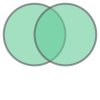

In [23]:
#| label: fig-overlapping-circles
#| fig-cap: Overlapping circles.

x = shapely.geometry.Point((0, 0)).buffer(1)
y = shapely.geometry.Point((1, 0)).buffer(1)
shapely.geometry.GeometryCollection([x, y])

Imagine you want to select not one circle or the other, but the space covered by both x and y. This can be done using the `.intersection` method from `shapely`, illustrated using objects named `x` and `y` which represent the left- and right-hand circles (@fig-intersection).

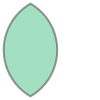

In [24]:
#| label: fig-intersection
#| fig-cap: Overlapping circles with a gray color indicating intersection between them. 

x.intersection(y)

### Subsetting and clipping

...

### Geometry unions {#sec-geometry-unions}

As we saw in @sec-vector-attribute-aggregation, spatial aggregation can silently dissolve the geometries of touching polygons in the same group. This is demonstrated in the code chunk below in which 49 `us_states` are aggregated into 4 regions using the `.dissolve` method:

In [25]:
regions = us_states.dissolve(by='REGION', aggfunc='sum').reset_index()
regions

,REGION,geometry,AREA,total_pop_10,total_pop_15
0,Midwest,MULTIPOLYGON (((-89.10077 36.94...,1.984047e+06,66514091.0,67546398.0
1,Norteast,MULTIPOLYGON (((-75.61724 39.83...,4.357609e+05,54909218.0,55989520.0
2,South,MULTIPOLYGON (((-81.38550 30.27...,2.314087e+06,112072990.0,118575377.0
3,West,MULTIPOLYGON (((-118.36998 32.8...,3.073145e+06,68444193.0,72264052.0


The result is shown in @fig-dissolve:

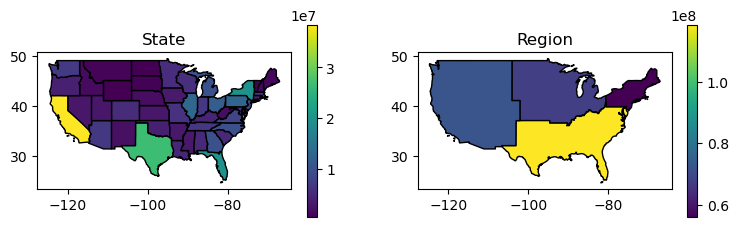

In [26]:
#| label: fig-dissolve
#| fig-cap: "Spatial aggregation on contiguous polygons, illustrated by aggregating the population of US states into regions, with population represented by color. Note the operation automatically dissolves boundaries between states."

fig, axes = plt.subplots(ncols=2, figsize=(9, 2.5))
us_states.plot(ax=axes[0], edgecolor='black', column='total_pop_15', legend=True)
regions.plot(ax=axes[1], edgecolor='black', column='total_pop_15', legend=True)
axes[0].set_title('State')
axes[1].set_title('Region');

What is going on in terms of the geometries? Behind the scenes, `.dissolve` combines the geometries and dissolve the boundaries between them using the [`.unary_union`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html#geopandas.GeoSeries.unary_union) method per group. This is demonstrated in the code chunk below which creates a united western US using the standalone `unary_union` operation:

In [27]:
us_west = us_states[us_states['REGION'] == 'West']
us_west_union = us_west['geometry'].unary_union

Note that the result is a `shapely` geometry, as the individual attributes are "lost" as part of dissolving. The result is shown in @fig-dissolve2.

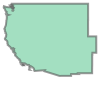

In [28]:
#| label: fig-dissolve2
#| fig-cap: Western US

us_west_union

To dissolve two (or more) groups of a `GeoDataFrame` into one geometry, we can either use a combined condition:

In [29]:
sel = (us_states['REGION'] == 'West') | (us_states['NAME'] == 'Texas')
texas_union = us_states[sel]
texas_union = texas_union['geometry'].unary_union

or concatenate the two separate subsets:

In [30]:
us_west = us_states[us_states['REGION'] == 'West']
texas = us_states[us_states['NAME'] == 'Texas']
texas_union = pd.concat([us_west, texas]).unary_union

and then dissove using `.unary_union`. The result is identical in both cases, shown in @fig-dissolve3.

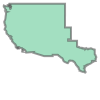

In [31]:
#| label: fig-dissolve3
#| fig-cap: Western US and Texas

texas_union

### Type transformations {#sec-type-transformations}

Transformation of geometries, from one type to another, also known as "geometry casting", is often required to facilitate spatial analysis. The `shapely` package can be used for geometry casting. The exact expression(s) depend on the specific transformation we are interested in. In general, you need to figure out the required input of the respective construstor function according to the "destination" geometry (e.g., `shapely.geometry.LineString`, etc.), then reshape the input of the "source" geometry into the right form to be passed to that function.

Let's create a `"MultiPoint"` to illustrate how geometry casting works on `shapely` geometry objects:

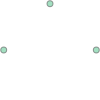

In [32]:
multipoint = shapely.geometry.MultiPoint([(1,1), (3,3), (5,1)])
multipoint

A `"LineString"` can be created using `shapely.geometry.LineString` from a `list` of points. Consequently, a `"MultiPoint"` can be converted to a `"LineString"` by extracting the individual points into a `list`, then passing them to `shapely.geometry.LineString`:

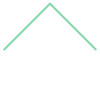

In [33]:
linestring = shapely.geometry.LineString(list(multipoint.geoms))
linestring

A `"Polygon"` can also be created using funtion `shapely.geometry.Polygon`, which acceps accepts a sequence of points. In principle, the last coordinate must be equal to the first, in order to form a closed shape. However, `shapely.geometry.Polygon` is able to complete the last coordinate automatically. Therefore:

In [34]:
list(multipoint.geoms)

[<POINT (1 1)>, <POINT (3 3)>, <POINT (5 1)>]

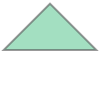

In [40]:
polygon = shapely.geometry.Polygon([[p.x, p.y] for p in multipoint.geoms])
polygon

The source `"MultiPoint"` geometry, and the derived `"LineString"` and `"Polygon"` geometries are shown in @fig-casting1. Note that we convert the `shapely` geometries to `GeoSeries` for easier multi-panel plotting:

In [ ]:
#| label: fig-casting1
#| fig-cap: Examples of linestring and polygon casted from a multipoint geometry.

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
gpd.GeoSeries(multipoint).plot(ax=axes[0])
gpd.GeoSeries(linestring).plot(ax=axes[1])
gpd.GeoSeries(polygon).plot(ax=axes[2])
axes[0].set_title("MultiPoint")
axes[1].set_title("LineString")
axes[2].set_title("Polygon");

Conversion from multipoint to linestring is a common operation that creates a line object from ordered point observations, such as GPS measurements or geotagged media. This allows spatial operations such as the length of the path traveled. Conversion from multipoint or linestring to polygon is often used to calculate an area, for example from the set of GPS measurements taken around a lake or from the corners of a building lot.

Our `"LineString"` geometry can be converted bact to a `"MultiPoint"` geometry by passing its coordinates directly to `shapely.geometry.MultiPoint`:

In [ ]:
# 'LineString' -> 'MultiPoint'
shapely.geometry.MultiPoint(linestring.coords)

The `"Polygon"` (exterior) coordinates can be passed to `shapely.geometry.MultiPoint` as well:

In [ ]:
# 'Polygon' -> 'MultiPoint'
shapely.geometry.MultiPoint(polygon.exterior.coords)

...

## Geometric operations on raster data {#sec-geo-ras}

### Geometric intersections

...

### Extent and origin

...

### Aggregation and disaggregation

...

### Resampling {#sec-raster-resampling}

...

## Exercises
